In [1]:

%matplotlib inline
from pipeline import Pipeline
from decoding_analysis import CVPipleline, LDADecoder, Decoding, OvertimePipelineDecoder
from erpanalysis import ERPAnalysis
from preprocessing import *
from mne_bids import BIDSPath
import matplotlib.pyplot as plt

import os

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, StratifiedKFold

from mne.decoding import Vectorizer, cross_val_multiscore

from sklearn import svm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

## Set BIDSPath

In [3]:
bids_root = os.path.join('data', 'P3')
bids_path = BIDSPath(subject='030', session='P3', task='P3',
                        datatype='eeg', suffix='eeg', root=bids_root)

## Initialize Pipeline and execute init actions

In [4]:
pipeline = Pipeline(bids_path, verbose=logging.ERROR)
pipeline.load_data()
pipeline.set_custom_events_mapping(task='P3')
pipeline.set_montage()

We will initialize an object of `ERPAnalysis` which will have all the data regarding the ERP analysis, we will also run the pipeline till the processing step

In [5]:
erp = ERPAnalysis(-0.1, 1)
pipeline.make_pipeline([CleaningData(bids_path), SimpleMNEFilter(0.1, 50, 'firwin'), PrecomputedICA(bids_path), erp])

# Decoding Analysis

Init the training data

In [6]:
epoch_train = erp.epochs['stimulus'].load_data().crop(0.1, 0.9).copy()
decoder = Decoding(epoch_train)
# data, labels = decoder.get_train(channels=['Cz', 'CPz'])

we will use the CSP feature transformer to transform the feature

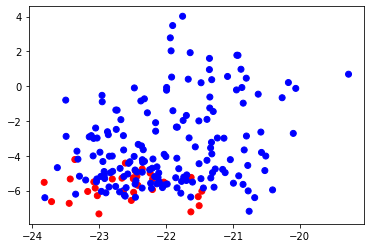

In [7]:
csp_data, labels = decoder.feature_transform();
plt.scatter(csp_data[:,0],csp_data[:,1],color=np.array(["red", "blue"])[np.where(labels == 1, 0, 1)])

In [8]:

lda = LDADecoder(); # Simple LDA classifier
lda.fit(csp_data, labels);
print('Accuracy of LDA classifier {}'.format(lda.predict(csp_data, labels)));

Accuracy of LDA classifier 0.845


## CrossValidation and Extension

We will now perform crossvalidation to avoid overfitting

In [9]:
lda_cv_pip = make_pipeline(Vectorizer(), StandardScaler(), LinearDiscriminantAnalysis(solver='svd'))
train_data, test_data, labels_train, labels_test = train_test_split(csp_data, labels, random_state=32);
lda = CVPipleline(lda_cv_pip, train_data, test_data, labels_train, labels_test)
lda.fit()
lda.predict()
lda.evaluate()

Clasification Report:
               precision    recall  f1-score   support

        Rare       1.00      0.11      0.20         9
    Frequent       0.84      1.00      0.91        41

    accuracy                           0.84        50
   macro avg       0.92      0.56      0.56        50
weighted avg       0.87      0.84      0.78        50

Accuracy of model: 0.84
Precision: 0.9183673469387755, Recall: 0.5555555555555556, f1-score:0.5555555555555556


(0.84, 0.5555555555555556)

we will use the `SVM` to classify our stimulus without doing feature transform CSP data

In [10]:
# Now we will use only two channels
data, labels = decoder.get_train(channels=['Cz', 'CPz'])
clf_svm = make_pipeline(Vectorizer(), StandardScaler(), svm.SVC(kernel='linear', C=1));
scores = cross_val_score(clf_svm, data, labels, cv=5);
for i in range(len(scores)):   
    print('Accuracy of ' + str(i+1) + 'th fold is ' + str(scores[i]));
print('Mean accuracy {}'.format(np.mean(scores)));

Accuracy of 1th fold is 0.85
Accuracy of 2th fold is 0.85
Accuracy of 3th fold is 0.85
Accuracy of 4th fold is 0.825
Accuracy of 5th fold is 0.825
Mean accuracy 0.8400000000000001


## Hyperparameter Optimization

In [11]:
#svm
clf_svm_pip = make_pipeline(Vectorizer(), StandardScaler(), svm.SVC(random_state=42));
parameters = {'svc__kernel':['linear', 'rbf', 'sigmoid'], 'svc__C':[0.1, 1, 10]}
gs_cv_svm = GridSearchCV(clf_svm_pip, parameters, scoring='accuracy', cv=StratifiedKFold(n_splits=5), return_train_score=True);

In [12]:
data, labels = decoder.get_train();
# train_data, test_data, labels_train, labels_test = train_test_split(csp_data, labels);
gs_cv_svm.fit(data, labels)
print('Best Parameters: {}'.format(gs_cv_svm.best_params_));
print('Best Score: {}'.format(gs_cv_svm.best_score_));

Best Parameters: {'svc__C': 0.1, 'svc__kernel': 'linear'}
Best Score: 0.8400000000000001


# Classify Over time

In [14]:
timeDecode = mne.decoding.SlidingEstimator(clf_svm)
epch_train = decoder.epochs.load_data().copy().resample(40)
scores = cross_val_multiscore(timeDecode, epch_train.get_data(), labels, cv=StratifiedKFold(n_splits=5), n_jobs=2)
print('Accuracy score {}'.format(np.mean(scores)));

Accuracy score 0.82390625


Plotting scores over time

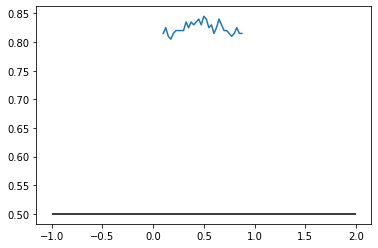

In [15]:
plt.plot(epch_train.times,scores.mean(axis=0))
plt.hlines(0.5,-1,2,'k')

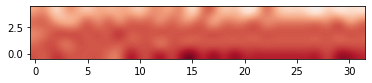

In [16]:
scores.shape
im = plt.imshow(scores, interpolation='lanczos', origin='lower', cmap='RdBu_r',vmin=0.2, vmax=1)
# plt.colorbar()

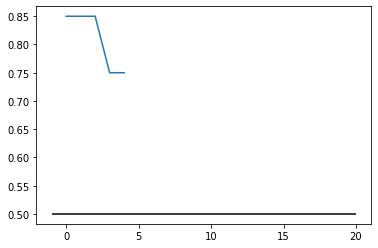

In [17]:
plt.plot(np.diag(scores))
plt.hlines(0.5,-1,20,'k')

In [18]:

# clrs = SKLearnPipelineDecoder(clf_svm)
# epoch_train = erp.epochs['stimulus/B']
# epoch_train = epoch_train.load_data().copy()
# clrs.fit(epoch_train, labels)
# scores = clrs.predict(w_size=1)
# scores
# plt.plot(clrs.timeVec,scores,'o-')
# plt.hlines(0.5,-1,4,'k')

In [19]:
clf_svm = make_pipeline(Vectorizer(), StandardScaler(), svm.SVC(kernel='linear', C=1))
clrs = OvertimePipelineDecoder(clf_svm)
# clrs
epochs, labels = decoder.epochs.copy(), decoder.epochs.events[:, -1]
clrs.fit(epochs, labels, resampling_freq=256)
scores = clrs.predict(w_size=0.5)
scores

array([nan, nan, nan, nan, nan, nan, nan])

# Analysing classification scores of Multiple Subjects by aggregating the `mne.io.Raw` of each subjects

Below, I am trying to find the accuracy and f-scores for the all stimulus conditions using `LDA` and `SVM` models

In [21]:
pipeline.load_multiple_subjects(40, preload=True)
# pipeline.set_custom_events_mapping(task='P3')
pipeline.apply_resampling(256)
erp = ERPAnalysis(-0.1, 0.8)
pipeline.compute_epochs(erp)

100%|██████████| 39/39 [00:42<00:00,  1.09s/it]


In [22]:
epoch_train = erp.epochs['stimulus'].copy()
decoder = Decoding(epoch_train)
data, labels = decoder.get_train(channels=['Cz', 'CPz'])

Again, we will use the `CSP` to transform the data, so that we can get features

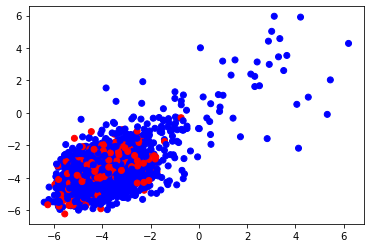

In [23]:
csp_data, labels = decoder.feature_transform();
plt.scatter(csp_data[:,0],csp_data[:,1],color=np.array(["red", "blue"])[np.where(labels == 1, 0, 1)])

In [25]:
lda = LDADecoder();
lda.fit(csp_data, labels);
print('Accuracy of LDA classifier {}'.format(lda.predict(csp_data, labels)));

Accuracy of LDA classifier 0.8674762407602957


In [26]:
train_data, test_data, labels_train, labels_test = train_test_split(data, labels)
clf_svm_pip = make_pipeline(Vectorizer(), StandardScaler(), svm.SVC(random_state=42))
parameters = {'svc__kernel':['linear', 'rbf', 'sigmoid'], 'svc__C':[0.1, 1, 10]}
gs_cv_svm = GridSearchCV(clf_svm_pip, parameters, scoring='accuracy', cv=StratifiedKFold(n_splits=5), return_train_score=True);
gs_cv_svm.fit(train_data, labels_train)
print('Best Parameters: {}'.format(gs_cv_svm.best_params_));
print('Best Score: {}'.format(gs_cv_svm.best_score_));

Best Parameters: {'svc__C': 0.1, 'svc__kernel': 'linear'}
Best Score: 0.8697183098591548


In [27]:
stim_data = decoder.get_all_stim()
train_data_A, test_data_A, labels_train_A, labels_test_A = train_test_split(stim_data['A']['data'].mean(axis=2), stim_data['A']['labels'], test_size=0.3, random_state=42)
train_data_B, test_data_B, labels_train_B, labels_test_B = train_test_split(stim_data['B']['data'].mean(axis=2), stim_data['B']['labels'], test_size=0.3, random_state=42)
train_data_C, test_data_C, labels_train_C, labels_test_C = train_test_split(stim_data['C']['data'].mean(axis=2), stim_data['C']['labels'], test_size=0.3, random_state=42)
train_data_D, test_data_D, labels_train_D, labels_test_D = train_test_split(stim_data['D']['data'].mean(axis=2), stim_data['D']['labels'], test_size=0.3, random_state=42)
train_data_E, test_data_E, labels_train_E, labels_test_E = train_test_split(stim_data['E']['data'].mean(axis=2), stim_data['E']['labels'], test_size=0.3, random_state=42)

In [29]:

# Linear Discriminant Analysis
scores= []
lda_cv_pip = make_pipeline(Vectorizer(), StandardScaler(), LinearDiscriminantAnalysis(solver='svd'))
lda = CVPipleline(lda_cv_pip, train_data_A, test_data_A, labels_train_A, labels_test_A)
lda.fit()
lda.predict()
scores.append(lda.evaluate())
lda = CVPipleline(lda_cv_pip, train_data_B, test_data_B, labels_train_B, labels_test_B)
lda.fit()
lda.predict()
scores.append(lda.evaluate())
lda = CVPipleline(lda_cv_pip, train_data_C, test_data_A, labels_train_C, labels_test_C)
lda.fit()
lda.predict()
scores.append(lda.evaluate())
lda = CVPipleline(lda_cv_pip, train_data_D, test_data_D, labels_train_D, labels_test_D)
lda.fit()
lda.predict()
scores.append(lda.evaluate())
lda = CVPipleline(lda_cv_pip, train_data_E, test_data_E, labels_train_E, labels_test_E)
lda.fit()
lda.predict()
scores.append(lda.evaluate())

Clasification Report:
               precision    recall  f1-score   support

        Rare       0.22      0.08      0.12        25
    Frequent       0.79      0.93      0.85        95

    accuracy                           0.75       120
   macro avg       0.51      0.50      0.49       120
weighted avg       0.67      0.75      0.70       120

Accuracy of model: 0.75
Precision: 0.5075075075075075, Recall: 0.5031578947368421, f1-score:0.48600799543118217
Clasification Report:
               precision    recall  f1-score   support

        Rare       0.21      0.12      0.16        24
    Frequent       0.78      0.87      0.82        84

    accuracy                           0.70       108
   macro avg       0.50      0.50      0.49       108
weighted avg       0.65      0.70      0.67       108

Accuracy of model: 0.7037037037037037
Precision: 0.49544072948328266, Recall: 0.49702380952380953, f1-score:0.48905972797161446
Clasification Report:
               precision    recall  f1

In [30]:
scores

[(0.75, 0.48600799543118217),
 (0.7037037037037037, 0.48905972797161446),
 (0.8, 0.48238677210639824),
 (0.7433628318584071, 0.4578990901571547),
 (0.8148148148148148, 0.49390815370196817)]